In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE # Pastikan library ini sudah terinstal!
import warnings

# Atur tampilan plot
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

In [17]:
print("1. MEMUAT DATA KLASIFIKASI...")

# Asumsi: Muat data yang sudah bersih dan ter-scaling dari Pra-pemrosesan I
try:
    train_df = pd.read_csv('data_train_preprocessed.csv')
    test_df = pd.read_csv('data_test_preprocessed.csv')
except FileNotFoundError:
    print("ERROR: Pastikan file 'data_train_preprocessed.csv' dan 'data_test_preprocessed.csv' tersedia.")
    raise

# GANTI INI: Kolom target Klasifikasi Anda
TARGET_CLASS = 'Job' 
y_class_train = train_df[TARGET_CLASS]
X_class_train = train_df.drop(TARGET_CLASS, axis=1)
y_class_test = test_df[TARGET_CLASS]
X_class_test = test_df.drop(TARGET_CLASS, axis=1)

# GANTI INI: Kolom numerik yang akan dimasukkan ke PCA
NUMERICAL_COLS_CLASS = ['Age', 'Duration'] 

print(f"Dimensi Awal Fitur (X_class_train): {X_class_train.shape}")

1. MEMUAT DATA KLASIFIKASI...
Dimensi Awal Fitur (X_class_train): (800, 23)



2. SKENARIO A: SELEKSI FITUR (LASSO L1)...
LASSO memilih 4 fitur.


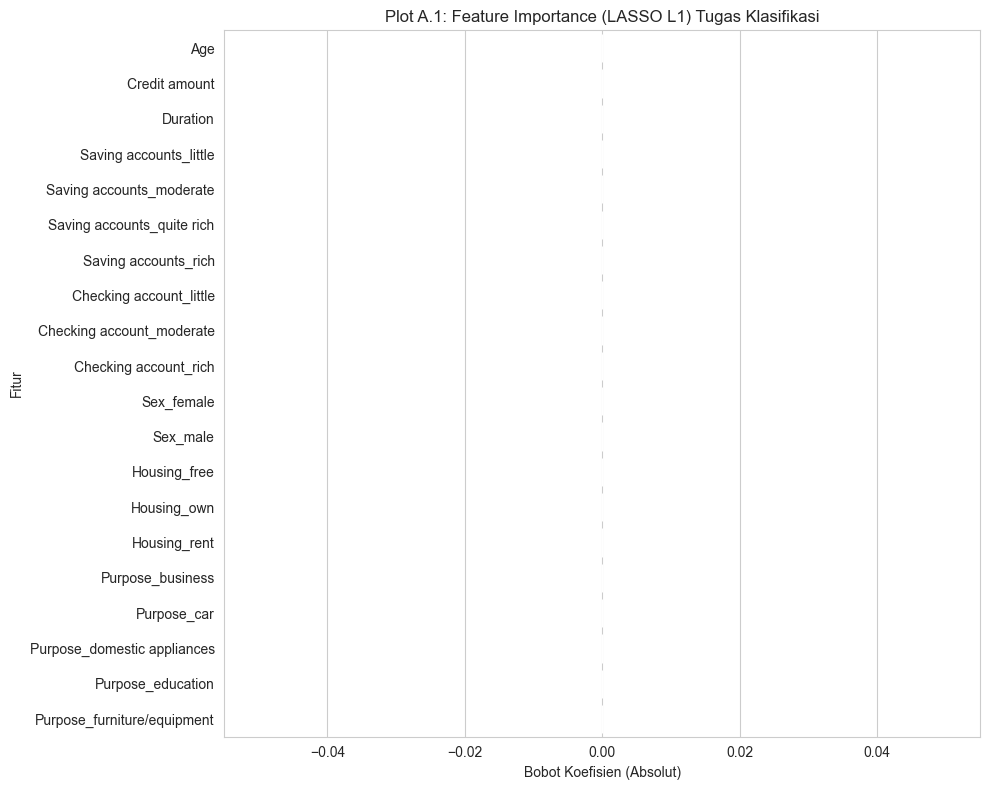

=> Disimpan: X_class_train_selected.csv


In [18]:
print("\n2. SKENARIO A: SELEKSI FITUR (LASSO L1)...")

# Latih model LASSO untuk seleksi fitur
l1_model_class = LogisticRegression(penalty='l1', C=0.05, solver='liblinear', random_state=42)
l1_selector = SelectFromModel(l1_model_class)
l1_selector.fit(X_class_train, y_class_train)

# Ambil fitur yang lolos seleksi
selected_features_class = X_class_train.columns[l1_selector.get_support()]

print(f"LASSO memilih {len(selected_features_class)} fitur.")

# --- KODE VISUALISASI PLOT A.1: FEATURE IMPORTANCE LASSO ---
l1_coefs = l1_selector.estimator_.coef_[0]
l1_coefs_df = pd.DataFrame({
    'Feature': X_class_train.columns,
    'Importance (Abs Coef)': np.abs(l1_coefs)
}).sort_values(by='Importance (Abs Coef)', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance (Abs Coef)',
    y='Feature',
    data=l1_coefs_df.head(20) # Plot 20 fitur teratas
)
plt.title('Plot A.1: Feature Importance (LASSO L1) Tugas Klasifikasi')
plt.xlabel('Bobot Koefisien (Absolut)')
plt.ylabel('Fitur')
plt.tight_layout()
plt.show()

# Buat dataframe baru dan simpan hasil Skenario A
X_class_train_selected = X_class_train[selected_features_class]
X_class_test_selected = X_class_test[selected_features_class]
X_class_train_selected.to_csv('X_class_train_selected.csv', index=False)
X_class_test_selected.to_csv('X_class_test_selected.csv', index=False)
print("=> Disimpan: X_class_train_selected.csv")


3. SKENARIO B: REDUKSI DIMENSI (PCA)...


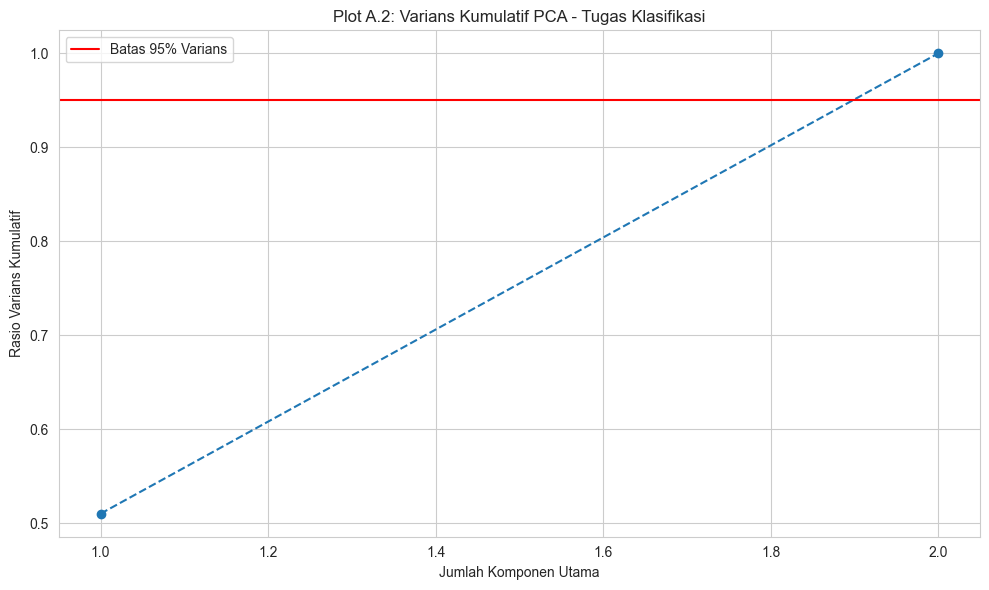

PCA memilih 2 komponen.
=> Disimpan: X_class_train_pca.csv


In [19]:
print("\n3. SKENARIO B: REDUKSI DIMENSI (PCA)...")

# Pisahkan data numerik dan biner
X_train_num = X_class_train[NUMERICAL_COLS_CLASS]
X_train_bin = X_class_train.drop(columns=NUMERICAL_COLS_CLASS, errors='ignore')
X_test_num = X_class_test[NUMERICAL_COLS_CLASS]
X_test_bin = X_class_test.drop(columns=NUMERICAL_COLS_CLASS, errors='ignore')

# --- KODE VISUALISASI PLOT A.2: VARIAN KUMULATIF PCA (Analisis Komponen) ---
# Fit PCA penuh pada data numerik (TANPA reduksi) untuk menghitung varians kumulatif
pca_full_class = PCA(random_state=42).fit(X_train_num)
cumulative_variance = np.cumsum(pca_full_class.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='red', linestyle='-', label='Batas 95% Varians')
plt.title('Plot A.2: Varians Kumulatif PCA - Tugas Klasifikasi')
plt.xlabel('Jumlah Komponen Utama')
plt.ylabel('Rasio Varians Kumulatif')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Inisialisasi PCA dengan n_components=0.95 untuk transformasi
pca_class = PCA(n_components=0.95, random_state=42)
pca_class.fit(X_train_num)
print(f"PCA memilih {pca_class.n_components_} komponen.")

# Transformasi dan Penggabungan
X_train_pca_transformed = pca_class.transform(X_train_num)
X_test_pca_transformed = pca_class.transform(X_test_num)

pc_cols = [f'PC{i+1}' for i in range(pca_class.n_components_)]
X_train_pca_df = pd.DataFrame(X_train_pca_transformed, columns=pc_cols, index=X_class_train.index)
X_test_pca_df = pd.DataFrame(X_test_pca_transformed, columns=pc_cols, index=X_class_test.index)

# Gabungkan data PCA dengan data biner (non-PCA)
X_class_train_pca = pd.concat([X_train_bin, X_train_pca_df], axis=1)
X_class_test_pca = pd.concat([X_test_bin, X_test_pca_df], axis=1)

# Simpan hasil Skenario B
X_class_train_pca.to_csv('X_class_train_pca.csv', index=False)
X_class_test_pca.to_csv('X_class_test_pca.csv', index=False)
print("=> Disimpan: X_class_train_pca.csv")

In [20]:
y_class_train.to_csv('y_class_train.csv', index=False, header=True)
y_class_test.to_csv('y_class_test.csv', index=False, header=True)
print("=> Disimpan: y_class_train.csv dan y_class_test.csv")
print("\n--- KLASIFIKASI OPTIMIZATION SELESAI ---")

=> Disimpan: y_class_train.csv dan y_class_test.csv

--- KLASIFIKASI OPTIMIZATION SELESAI ---
